# **Streaming Content Strategy Analysis Overview**

This notebook analyzes TV content strategy across five major streaming services — Netflix, Hulu, Disney+, Amazon Prime, and HBO Max. The goal is to identify what each platform emphasizes, where gaps exist, and what types of content are consistently successful (i.e., highly rated and long-running).

---

**Section 1–2: Setup and Data Loading**  
- Loads cleaned datasets at both the show-level and tag-level.
- Filters to exclusive titles per service to enable fair comparison.

---

**Section 3: Tag Cleaning**  
- Removes noisy or unlabeled clusters to improve signal quality in downstream analyses.

---

**Section 4–5: Tag Cluster Proportions**  
- Computes the proportion of exclusive titles within each thematic cluster per platform.
- Visualizes using a stacked horizontal bar chart to compare thematic focus.

**Key Insight:**  
Each service exhibits a distinct content strategy. For example, Disney+ emphasizes youth-friendly music and friendship content, Netflix focuses on supernatural, sci-fi, and political themes, and HBO Max invests in cerebral and historically grounded storytelling.

---

**Section 6: Top Tag Clusters per Service**  
- Extracts the top 3–5 most dominant tag clusters per platform.
- Includes bar plots for deeper comparative insight.

---

**Section 7: Gap Analysis (Whitespace Detection)**  
- Identifies two types of underrepresented content:
  - **Absolute gaps**: Themes with <3% presence across all services.
  - **Platform-specific gaps**: Themes that are missing from one platform but present (>5%) on others.
- Visualized through annotated heatmaps for clear identification.

---

**Section 8: Success Driver Analysis**  
- Defines "successful shows" as those with:
  - IMDB ratings in the top 20th percentile
  - Two or more seasons
- Compares tag cluster frequencies between successful shows and the full dataset.
- Computes an **overperformance ratio** to identify clusters that are disproportionately common among successful content.

**Key Takeaway:**  
Clusters like *Mature Drama & Crime*, *Teen Life & Coming-of-Age*, and *Political Espionage & Revenge* are strongly overrepresented in successful shows. These genres offer high potential for both critical reception and audience longevity.

---

**Final Outputs:**  
- Platform-specific genre priorities  
- Genre whitespace across and within platforms  
- Genre clusters linked to high-performing, long-running content  


# **Data Ingestion & Filtering**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


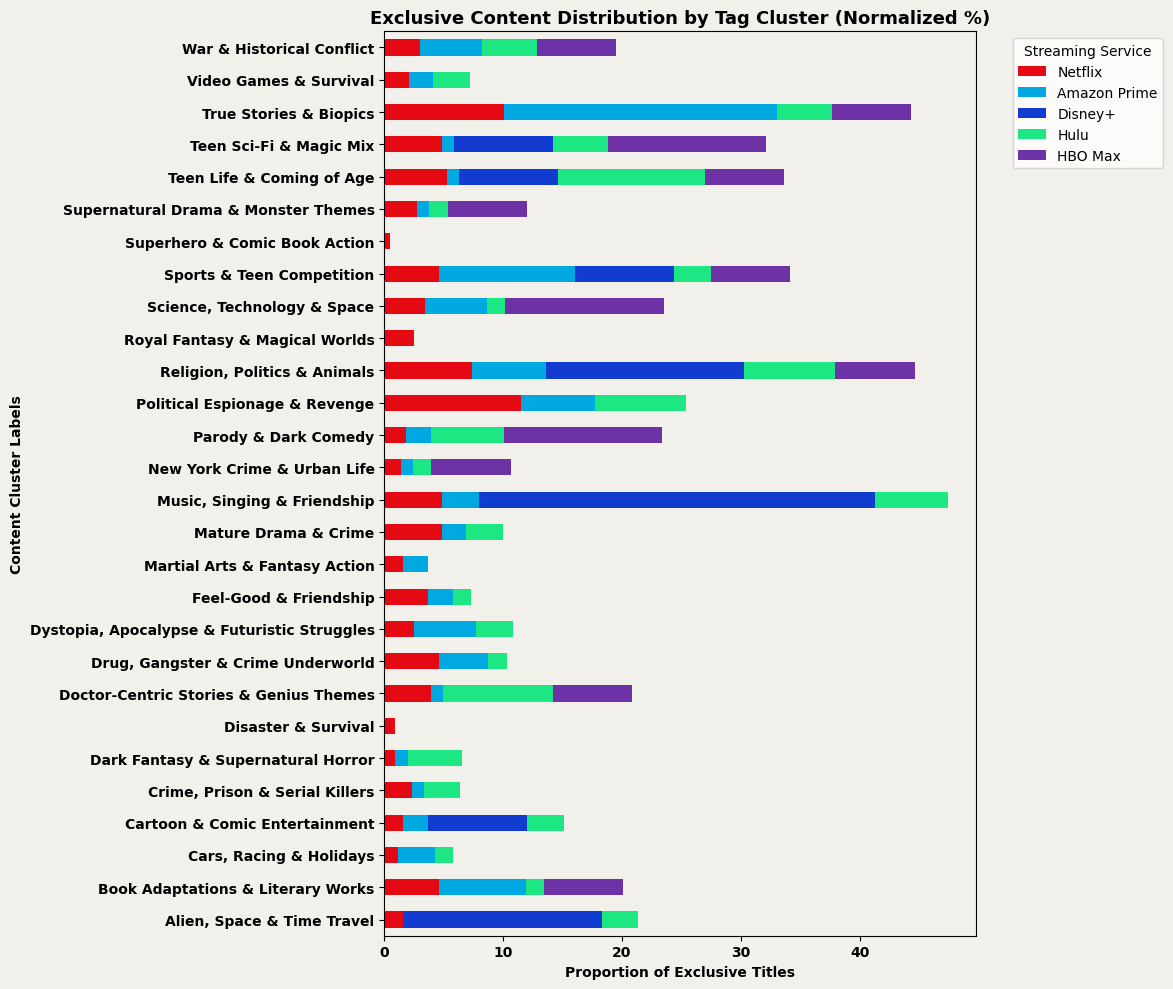

In [5]:
# ============================================
# SECTION 1: Imports & Drive Setup
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ============================================
# SECTION 2: Data Loading
# ============================================
# Load processed show-level dataset
df = pd.read_csv('/content/drive/MyDrive/DSO 574 - #3 Streaming Project/Dataset/tags_clustering.csv')
df

# Filter to exclusive titles only
exclusive_df = df[(df['Exclusive Service'] == 1)]
exclusive_df.head()
exclusive_df['Service'].value_counts()

# Load exploded tag-level dataset
exploded_tags = pd.read_csv('/content/drive/MyDrive/DSO 574 - #3 Streaming Project/Dataset/exploded_tags.csv')
exploded_tags['Service'].value_counts()

# ============================================
# SECTION 3: Tag Cleaning & Filtering
# ============================================
# Remove unwanted tag clusters
exploded_tags = exploded_tags[(exploded_tags['Tag_Cluster_Labels'] != 'Disney Core Themes')]
exploded_tags = exploded_tags[(exploded_tags['Tag_Cluster_Labels'] != 'Missing / Unlabeled Data')]

# ============================================
# SECTION 4: Compute Tag Cluster Proportions
# ============================================
# Create service x tag cluster matrix (counts)
tag_cluster_counts = exploded_tags.groupby('Service')['Tag_Cluster_Labels'].value_counts().unstack()

# Convert to row-wise proportions and transpose
tag_cluster_proportions = round(tag_cluster_counts.div(tag_cluster_counts.sum(axis=1), axis=0) * 100, 2)
tag_cluster_proportions = tag_cluster_proportions.T.fillna(0)

tag_cluster_proportions

# ============================================
# SECTION 5: Plotting (Stacked Horizontal Bar)
# ============================================

# Step 1: Define raw platform keys and their associated colors
platform_palette = {
    'netflix': '#E50914',
    'amazon_prime': '#00A8E1',
    'disney_plus': '#113CCF',
    'hulu_plus': '#1CE783',
    'hbo_max': '#6E32A7'
}

# Step 2: Human-readable platform names
platform_name_map = {
    'netflix': 'Netflix',
    'amazon_prime': 'Amazon Prime',
    'disney_plus': 'Disney+',
    'hulu_plus': 'Hulu',
    'hbo_max': 'HBO Max'
}

# Step 3: Reorder DataFrame columns to match palette
ordered_columns = list(platform_palette.keys())
tag_cluster_proportions = tag_cluster_proportions[ordered_columns]

# Step 4: Set color order accordingly
plot_colors = [platform_palette[col] for col in ordered_columns]

# Step 5: Create stacked horizontal bar plot
ax = tag_cluster_proportions.plot(
    kind='barh',
    stacked=True,
    figsize=(12, 10),
    color=plot_colors
)

# Step 6: Titles and labels
plt.title('Exclusive Content Distribution by Tag Cluster (Normalized %)', fontsize=13, fontweight='bold')
plt.xlabel('Proportion of Exclusive Titles', fontsize=10, fontweight='bold')
plt.ylabel('Content Cluster Labels', fontsize=10, fontweight='bold')
plt.xticks(rotation=0, fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')

# Step 7: Legend with display names
plt.legend(
    labels=[platform_name_map[col] for col in ordered_columns],
    title='Streaming Service',
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

# Step 8: Set figure background color
fig = plt.gcf()
fig.patch.set_facecolor('#f1f0ea')     # Figure background
ax.set_facecolor('#f1f0ea')            # Axes background

plt.tight_layout()
plt.show()


# **Q1: What type of content is sought after by streaming platforms?**

Exclusive tag clusters reveal the themes each platform prioritizes.

**Highlights:**
- **Disney+**: Dominates in *Music, Singing & Friendship* and *Feel-Good* clusters → strong brand alignment with nostalgic, youth-friendly content.
- **Netflix**: Over-indexes in *Teen Sci-Fi & Magic*, *Political Espionage*, and *Supernatural Drama* → investment in genre-driven, bingeable narratives.
- **HBO Max**: Leans into *War*, *Science*, and *Dark Comedy* → favors prestige and intellectually rich content.

**Visualization:**
- Horizontal bars show each platform’s top 3–5 tag clusters based on exclusive title share.


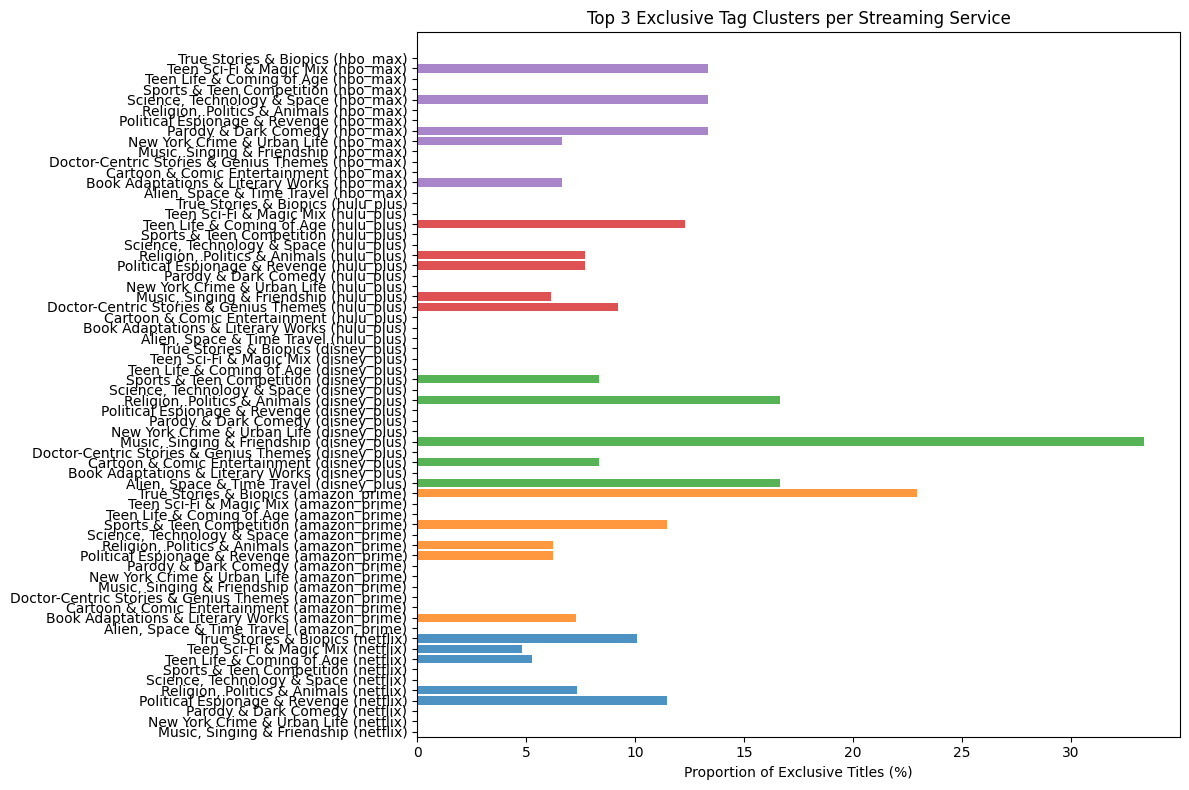

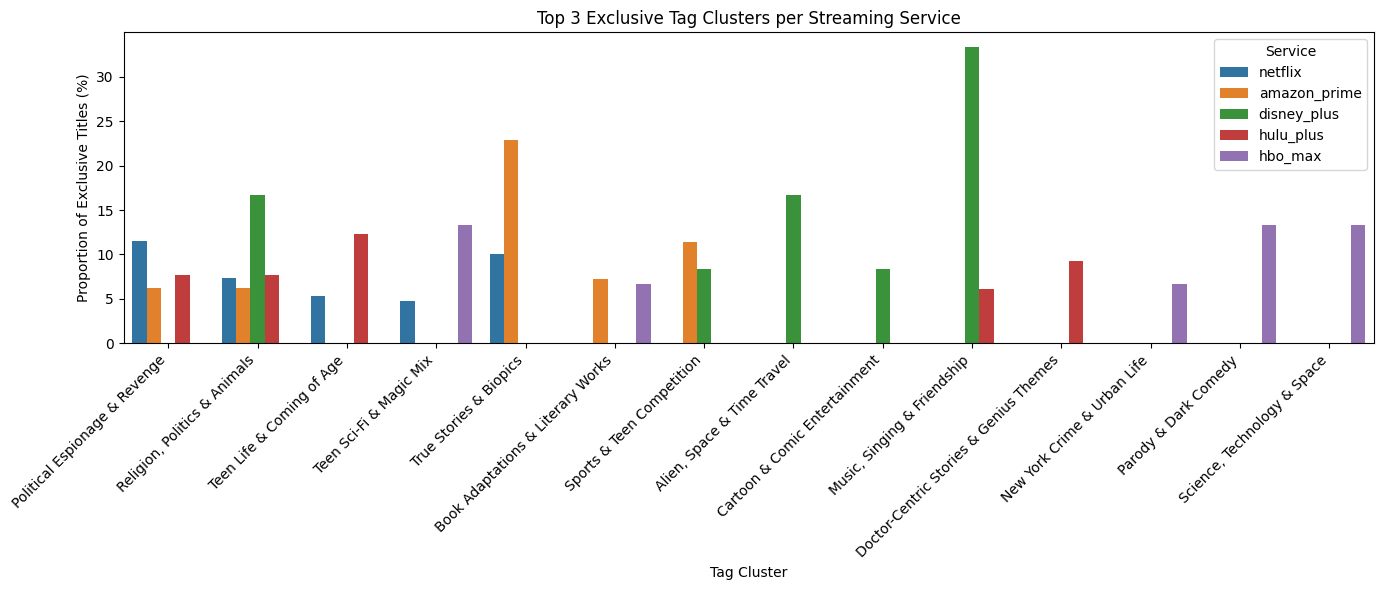

In [6]:
# ============================================
# SECTION 6: Top Exclusive Clusters per Service
# ============================================
"""
Q1: What type of content is sought after by streaming platforms?

- Strategy: Focus on the top tag clusters (themes) with the highest share for each platform.
- This reveals which themes are overrepresented in each exclusive catalog.
"""

# --------------------------------------------
# Step 1: Get Top Tag Clusters per Service
# --------------------------------------------
top_clusters_per_service = {}

for service in tag_cluster_proportions.columns:
    top_clusters = (
        tag_cluster_proportions[service]
        .sort_values(ascending=False)
        .head(5)  # or head(3) if you only want the top 3
    )
    top_clusters_per_service[service] = top_clusters

# Convert to DataFrame
top_df = pd.DataFrame(top_clusters_per_service)
top_df

# ============================================
# Optional Plot 1: BarH per Service
# ============================================

import matplotlib.pyplot as plt
import pandas as pd

# Prepare data for barh
plot_df = top_df.copy().reset_index().rename(columns={'index': 'Tag_Cluster_Labels'})
plot_long = plot_df.melt(id_vars='Tag_Cluster_Labels', var_name='Service', value_name='Proportion')

# Horizontal bar plot per label-service pair
plt.figure(figsize=(12, 8))
for i, service in enumerate(plot_long['Service'].unique()):
    subset = plot_long[plot_long['Service'] == service]
    plt.barh(
        y=[f"{row['Tag_Cluster_Labels']} ({service})" for _, row in subset.iterrows()],
        width=subset['Proportion'],
        label=service,
        alpha=0.8
    )

plt.xlabel('Proportion of Exclusive Titles (%)')
plt.title('Top 3 Exclusive Tag Clusters per Streaming Service')
plt.tight_layout()
plt.show()

# ============================================
# Optional Plot 2: Grouped Barplot (Seaborn)
# ============================================

import seaborn as sns

# Reuse melted long-format data
plot_df = top_df.fillna(0).copy().reset_index().rename(columns={'index': 'Tag_Cluster_Labels'})
plot_long = plot_df.melt(id_vars='Tag_Cluster_Labels', var_name='Service', value_name='Proportion')
plot_long = plot_long[plot_long['Proportion'] > 0]  # drop 0s / NaNs

# Grouped barplot
plt.figure(figsize=(14, 6))
sns.barplot(
    data=plot_long,
    x='Tag_Cluster_Labels',
    y='Proportion',
    hue='Service'
)

plt.xticks(rotation=45, ha='right')
plt.xlabel('Tag Cluster')
plt.ylabel('Proportion of Exclusive Titles (%)')
plt.title('Top 3 Exclusive Tag Clusters per Streaming Service')
plt.legend(title='Service')
plt.tight_layout()
plt.show()


# **Q2: What content is not currently being offered? (Gaps / Whitespace)**

## **Gap Detection + Heatmap Visualization**

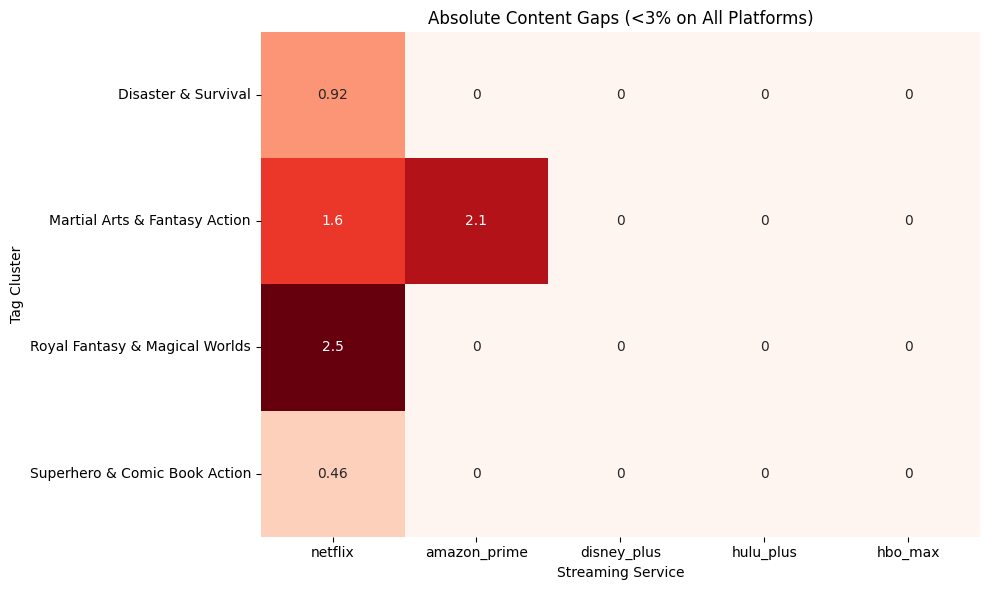

Service,netflix,amazon_prime,disney_plus,hulu_plus,hbo_max
Tag_Cluster_Labels,,,,,
Book Adaptations & Literary Works,4.59,7.29,0.0,1.54,6.67
Doctor-Centric Stories & Genius Themes,3.90,1.04,0.0,9.23,6.67
"Dystopia, Apocalypse & Futuristic Struggles",2.52,5.21,0.0,3.08,0.00
New York Crime & Urban Life,1.38,1.04,0.0,1.54,6.67
Parody & Dark Comedy,1.83,2.08,0.0,6.15,13.33
Political Espionage & Revenge,11.47,6.25,0.0,7.69,0.00
"Science, Technology & Space",3.44,5.21,0.0,1.54,13.33
Supernatural Drama & Monster Themes,2.75,1.04,0.0,1.54,6.67
True Stories & Biopics,10.09,22.92,0.0,4.62,6.67


In [7]:
# ============================================
# SECTION 7A: Content Gap Detection
# ============================================
"""
Q2: What content is NOT currently being offered? (Whitespace Analysis)

- Strategy 1: Absolute Gaps → content types nearly absent across ALL platforms.
- Strategy 2: Relative Gaps → categories missing from ONE platform but present on others.
"""

# ----------------------
# Absolute Gaps (<3% everywhere)
# ----------------------
threshold = 3
absolute_gaps = tag_cluster_proportions[
    (tag_cluster_proportions < threshold).all(axis=1)
]
absolute_gaps

# Heatmap for absolute gaps
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(absolute_gaps, annot=True, cmap='Reds', cbar=False)
plt.title('Absolute Content Gaps (<3% on All Platforms)')
plt.xlabel('Streaming Service')
plt.ylabel('Tag Cluster')
plt.tight_layout()
plt.show()

# ----------------------
# Platform-Specific Gaps (under <1%, others >5%)
# ----------------------
low_threshold = 1.0
high_threshold = 5

platform_gaps = {}
for service in tag_cluster_proportions.columns:
    gaps = tag_cluster_proportions[
        (tag_cluster_proportions[service] < low_threshold) &
        (tag_cluster_proportions.drop(columns=service) > high_threshold).any(axis=1)
    ]
    platform_gaps[service] = gaps

# View gaps for each service (optional)
platform_gaps['netflix']
platform_gaps['amazon_prime']
platform_gaps['hulu_plus']
platform_gaps['hbo_max']
platform_gaps['disney_plus']


## **Categorical Gap Heatmaps (Color-Coded)**

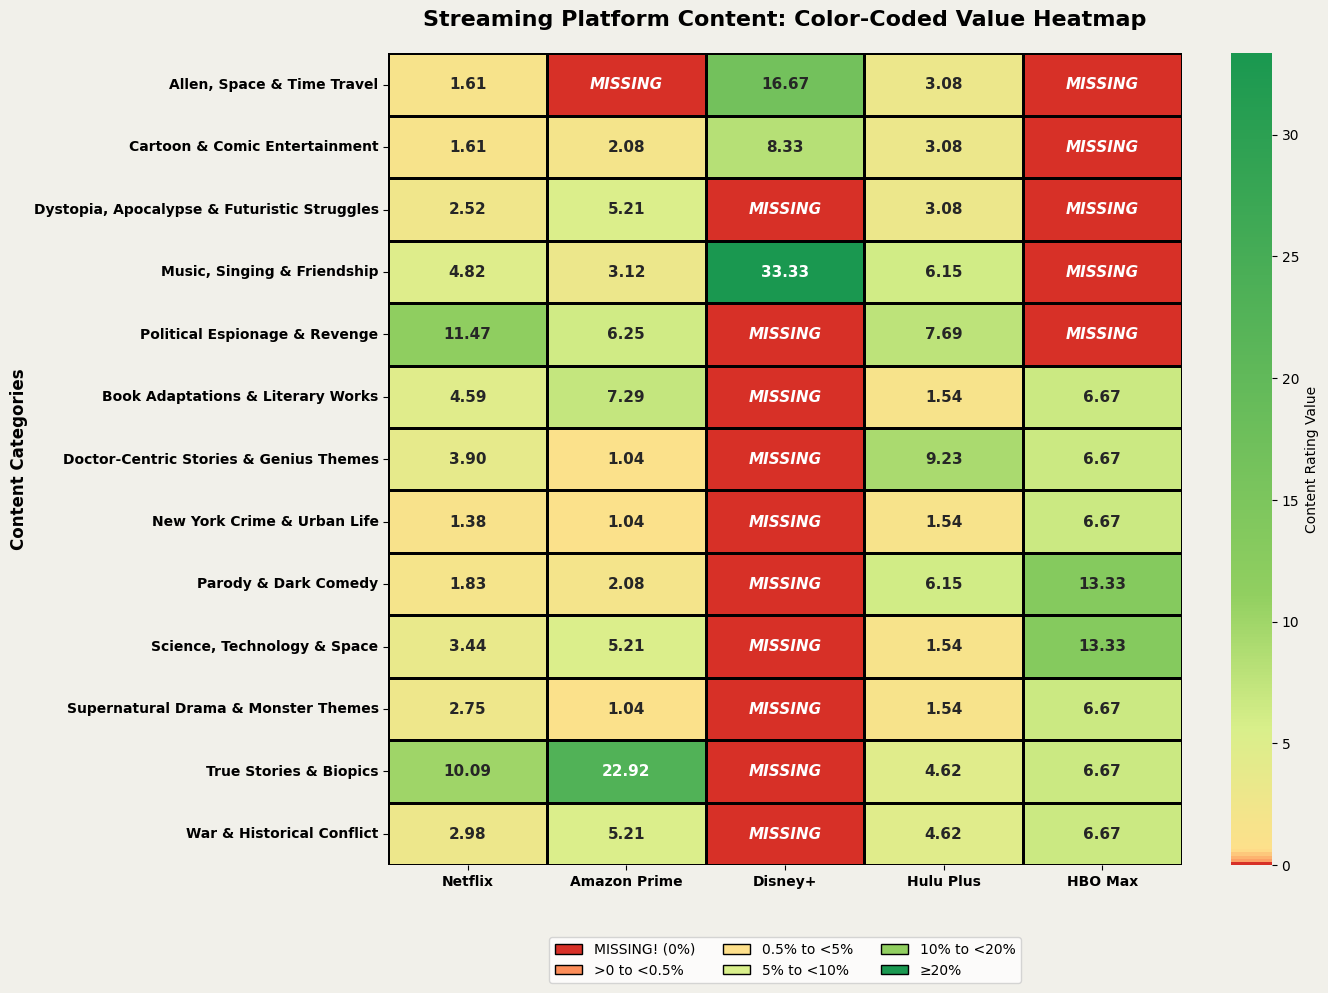

In [8]:
# ============================================
# SECTION 7B: Gap Heatmaps (Color-Coded)
# ============================================

# ----------------------
# Heatmap 1: Full Tag Cluster Map
# ----------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

data = {
    'Tag_Cluster_Labels': [
        'Allen, Space & Time Travel', 'Cartoon & Comic Entertainment', 'Dystopia, Apocalypse & Futuristic Struggles',
        'Music, Singing & Friendship', 'Political Espionage & Revenge', 'Book Adaptations & Literary Works',
        'Doctor-Centric Stories & Genius Themes', 'New York Crime & Urban Life', 'Parody & Dark Comedy',
        'Science, Technology & Space', 'Supernatural Drama & Monster Themes', 'True Stories & Biopics',
        'War & Historical Conflict'
    ],
    'Netflix': [1.61, 1.61, 2.52, 4.82, 11.47, 4.59, 3.90, 1.38, 1.83, 3.44, 2.75, 10.09, 2.98],
    'Amazon Prime': [0.0, 2.08, 5.21, 3.12, 6.25, 7.29, 1.04, 1.04, 2.08, 5.21, 1.04, 22.92, 5.21],
    'Disney+': [16.67, 8.33, 0.0, 33.33, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    'Hulu Plus': [3.08, 3.08, 3.08, 6.15, 7.69, 1.54, 9.23, 1.54, 6.15, 1.54, 1.54, 4.62, 4.62],
    'HBO Max': [0.0, 0.0, 0.0, 0.0, 0.0, 6.67, 6.67, 6.67, 13.33, 13.33, 6.67, 6.67, 6.67]
}
df = pd.DataFrame(data).set_index('Tag_Cluster_Labels')

raw_thresholds = [0, 0.001, 0.5, 5, 10, 30]
positions = [(val - min(raw_thresholds)) / (max(raw_thresholds) - min(raw_thresholds)) for val in raw_thresholds]
colors = ['#d73027', '#fc8d59', '#fee08b', '#d9ef8b', '#91cf60', '#1a9850']
cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(positions, colors)))

annotations = np.empty_like(df.values, dtype=object)
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        val = df.values[i, j]
        annotations[i, j] = "MISSING" if val == 0 else f"{val:.2f}"

plt.figure(figsize=(14, 10))
ax = sns.heatmap(df, annot=annotations, fmt="", cmap=cmap,
                 linewidths=1, linecolor='black',
                 cbar_kws={'label': 'Content Rating Value'})

for i, text in enumerate(ax.texts):
    row = i // df.shape[1]
    col = i % df.shape[1]
    val = df.iloc[row, col]
    text.set_fontsize(11)
    text.set_weight('bold')
    if val == 0:
        text.set_color('white')
        text.set_style('italic')

plt.title('Streaming Platform Content: Color-Coded Value Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Content Categories', fontsize=12, fontweight='bold')
plt.xticks(rotation=0, fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')

legend_elements = [
    Patch(facecolor='#d73027', edgecolor='black', label='MISSING! (0%)'),
    Patch(facecolor='#fc8d59', edgecolor='black', label='>0 to <0.5%'),
    Patch(facecolor='#fee08b', edgecolor='black', label='0.5% to <5%'),
    Patch(facecolor='#d9ef8b', edgecolor='black', label='5% to <10%'),
    Patch(facecolor='#91cf60', edgecolor='black', label='10% to <20%'),
    Patch(facecolor='#1a9850', edgecolor='black', label='≥20%')
]
plt.legend(handles=legend_elements, loc='upper center',
           bbox_to_anchor=(0.5, -0.08), ncol=3, fontsize=10)

fig = plt.gcf()
fig.patch.set_facecolor('#f1f0ea')
ax.set_facecolor('#f1f0ea')
plt.tight_layout()
plt.show()


# **Q3: Identify which content clusters are most overrepresented in successful shows**

In [9]:
# --------------------------------------------
# BLOCK A: Define "Success" & Compute Tag Frequencies
# --------------------------------------------

# Calculate rating threshold (top 20%)
rating_threshold = exploded_tags['IMDB'].quantile(0.8)

# Filter successful shows
successful_shows = exploded_tags[
    (exploded_tags['IMDB'] >= rating_threshold) &
    (exploded_tags['Seasons'] >= 2)
]

# Explode tag clusters for successful shows
successful_exploded = successful_shows.explode('Tag_Cluster_Labels')

# Frequency of each tag cluster in successful subset
success_cluster_counts = (
    successful_exploded['Tag_Cluster_Labels']
    .value_counts(normalize=True) * 100
).sort_values(ascending=False)

# Total cluster distribution
total_exploded = exploded_tags.explode('Tag_Cluster_Labels')
total_cluster_counts = (
    total_exploded['Tag_Cluster_Labels']
    .value_counts(normalize=True) * 100
)

# Overperformance ratio = (Successful % / Overall %)
overperformance = (success_cluster_counts / total_cluster_counts).dropna().sort_values(ascending=False)


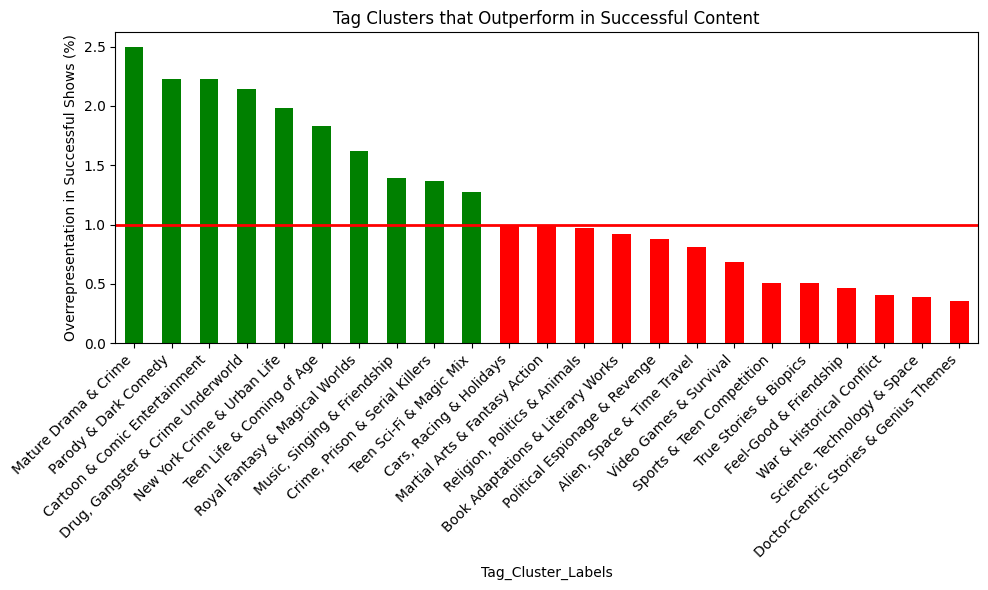

In [10]:
# --------------------------------------------
# BLOCK B: Basic Overperformance Bar Plot
# --------------------------------------------

import matplotlib.pyplot as plt

colors = ['green' if x > 1 else 'red' for x in overperformance]
plt.figure(figsize=(10, 6))
overperformance.plot(kind='bar', color=colors)
plt.axhline(y=1, color='red', linestyle='-', linewidth=2)
plt.ylabel('Overrepresentation in Successful Shows (%)')
plt.title('Tag Clusters that Outperform in Successful Content')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/tmp/ipython-input-11-3848787267.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=overperformance.index, y=overperformance.values, palette=colors)


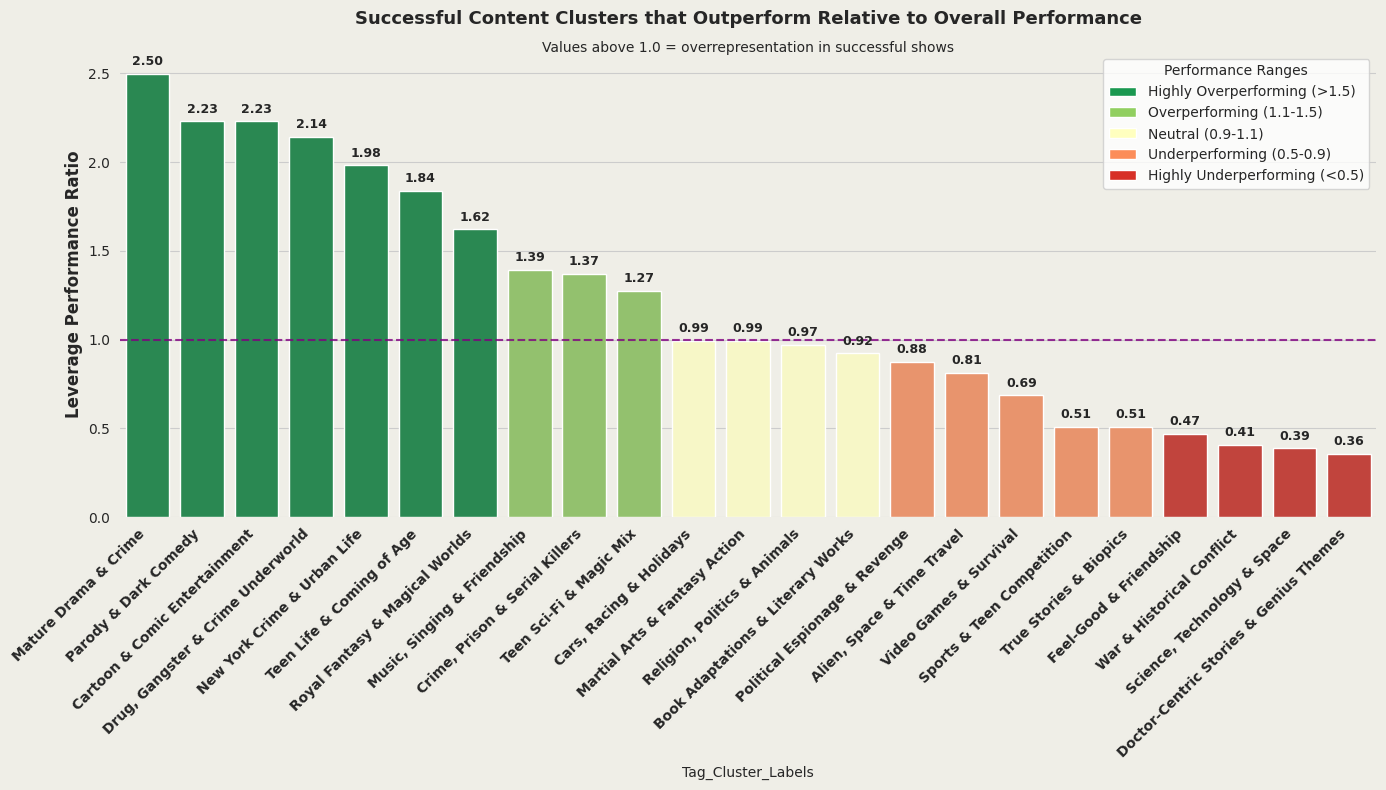

In [11]:
# --------------------------------------------
# BLOCK C: Styled Overperformance Chart (Color-Coded)
# --------------------------------------------

import seaborn as sns
import numpy as np
from matplotlib.patches import Patch

sns.set_style("whitegrid")
plt.figure(figsize=(14, 8))

# Custom color function
def get_color(value):
    if value > 1.5: return '#1a9850'
    elif value > 1.1: return '#91cf60'
    elif value > 0.9: return '#ffffbf'
    elif value > 0.5: return '#fc8d59'
    else: return '#d73027'

colors = [get_color(x) for x in overperformance]
ax = sns.barplot(x=overperformance.index, y=overperformance.values, palette=colors)
plt.axhline(y=1, color='purple', linestyle='--', linewidth=1.5, alpha=0.8)

# Labels
for i, v in enumerate(overperformance):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center', fontsize=9, fontweight='bold')

sns.despine(left=True, bottom=True)
legend_elements = [
    Patch(facecolor='#1a9850', label='Highly Overperforming (>1.5)'),
    Patch(facecolor='#91cf60', label='Overperforming (1.1-1.5)'),
    Patch(facecolor='#ffffbf', label='Neutral (0.9-1.1)'),
    Patch(facecolor='#fc8d59', label='Underperforming (0.5-0.9)'),
    Patch(facecolor='#d73027', label='Highly Underperforming (<0.5)')
]
plt.legend(handles=legend_elements, loc='upper right', title='Performance Ranges')

plt.ylabel('Leverage Performance Ratio', fontsize=12, fontweight='bold')
plt.title('Successful Content Clusters that Outperform Relative to Overall Performance', fontsize=13, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10, fontweight='bold')
plt.text(0.5, 1, 'Values above 1.0 = overrepresentation in successful shows', ha='center', fontsize=10, transform=ax.transAxes)
fig = plt.gcf()
fig.patch.set_facecolor('#efeee7')
ax.set_facecolor('#efeee7')
plt.tight_layout()
plt.show()

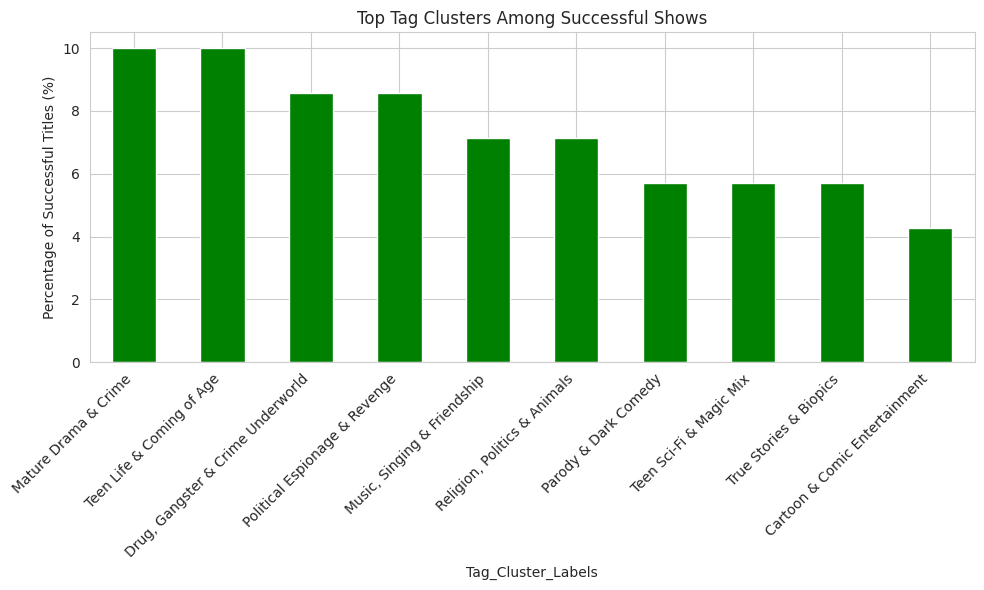

In [12]:
# --------------------------------------------
# BLOCK D: Top Successful Clusters by Raw Proportion
# --------------------------------------------

success_cluster_counts.head(10).plot(kind='bar', figsize=(10, 6), color='green')
plt.ylabel('Percentage of Successful Titles (%)')
plt.title('Top Tag Clusters Among Successful Shows')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/tmp/ipython-input-13-2007632121.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='proportion', y='Tag_Cluster_Labels', data=df, palette=colors, orient='h')


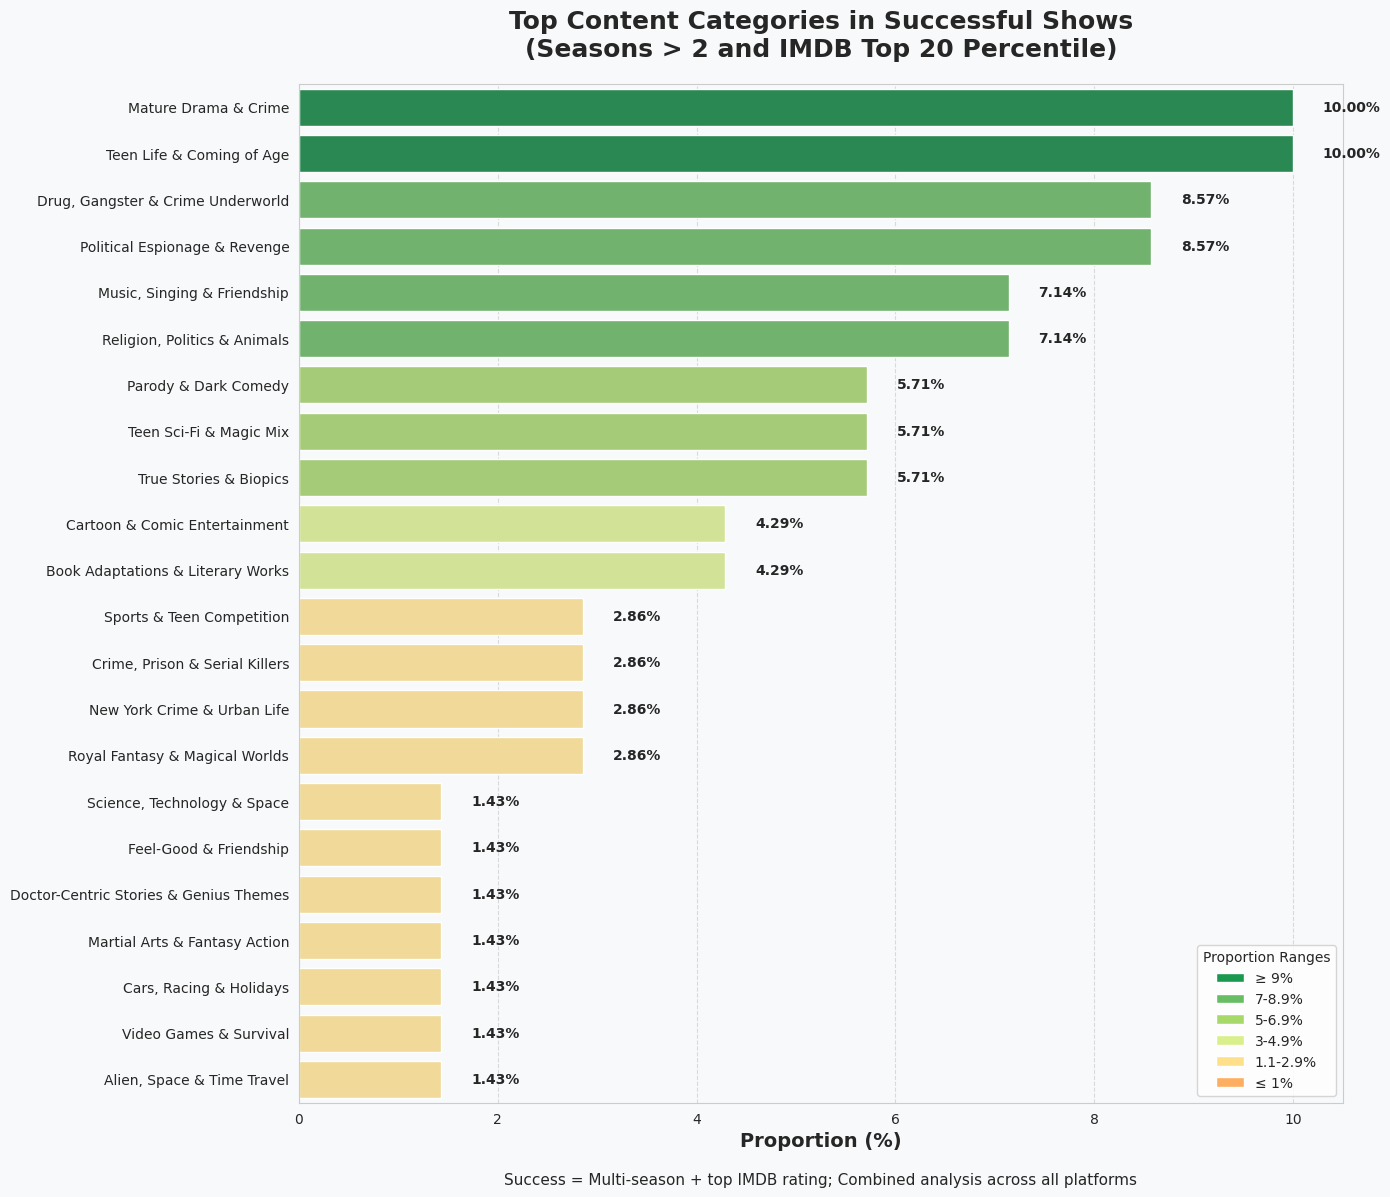

In [13]:
# --------------------------------------------
# BLOCK E: Horizontal Bar Chart of Top Successful Clusters
# --------------------------------------------

data = {
    'Tag_Cluster_Labels': [
        'Mature Drama & Crime', 'Teen Life & Coming of Age', 'Drug, Gangster & Crime Underworld',
        'Political Espionage & Revenge', 'Music, Singing & Friendship', 'Religion, Politics & Animals',
        'Parody & Dark Comedy', 'Teen Sci-Fi & Magic Mix', 'True Stories & Biopics',
        'Cartoon & Comic Entertainment', 'Book Adaptations & Literary Works', 'Sports & Teen Competition',
        'Crime, Prison & Serial Killers', 'New York Crime & Urban Life', 'Royal Fantasy & Magical Worlds',
        'Science, Technology & Space', 'Feel-Good & Friendship', 'Doctor-Centric Stories & Genius Themes',
        'Martial Arts & Fantasy Action', 'Cars, Racing & Holidays', 'Video Games & Survival',
        'Alien, Space & Time Travel'
    ],
    'proportion': [
        10.0, 10.0, 8.57, 8.57, 7.14, 7.14, 5.71, 5.71,
        5.71, 4.29, 4.29, 2.86, 2.86, 2.86, 2.86, 1.43,
        1.43, 1.43, 1.43, 1.43, 1.43, 1.43
    ]
}
df = pd.DataFrame(data).sort_values('proportion', ascending=False)

# Color by proportion bins
def get_color(val):
    if val >= 9: return '#1a9850'
    elif val >= 7: return '#66bd63'
    elif val >= 5: return '#a6d96a'
    elif val >= 3: return '#d9ef8b'
    elif val > 1: return '#fee08b'
    else: return '#fdae61'

colors = [get_color(x) for x in df['proportion']]

plt.figure(figsize=(14, 12))
ax = sns.barplot(x='proportion', y='Tag_Cluster_Labels', data=df, palette=colors, orient='h')

for i, v in enumerate(df['proportion']):
    ax.text(v + 0.3, i, f'{v:.2f}%', va='center', fontsize=10, fontweight='bold')

ax.set_facecolor('#f8f9fa')
plt.gcf().set_facecolor('#f8f9fa')
plt.title('Top Content Categories in Successful Shows\n(Seasons > 2 and IMDB Top 20 Percentile)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Proportion (%)', fontsize=14, fontweight='bold')
plt.ylabel('')

legend_elements = [
    Patch(facecolor='#1a9850', label='≥ 9%'),
    Patch(facecolor='#66bd63', label='7-8.9%'),
    Patch(facecolor='#a6d96a', label='5-6.9%'),
    Patch(facecolor='#d9ef8b', label='3-4.9%'),
    Patch(facecolor='#fee08b', label='1.1-2.9%'),
    Patch(facecolor='#fdae61', label='≤ 1%')
]
plt.legend(handles=legend_elements, loc='lower right', title='Proportion Ranges')

plt.text(0.5, -0.08,
         'Success = Multi-season + top IMDB rating; Combined analysis across all platforms',
         ha='center', fontsize=11, transform=ax.transAxes)
ax.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
